# Домашнее задание по курсу «Машинное обучение», тема «Прогнозирование»

## Условие 1

В файле «domations.csv» находится выборка с информацией об участниках программы
пожертвования денег на нужды ветеранских организаций. 

Каждая запись – один человек из списка рассылки. 

1) У него есть социо-демографические признаки:
 - пол
 - возраст
 - медианная оценка дохода в районе его проживания, 
 - является ли он домовладельцем и т.д. и т.д.,
2) Поведенческие признаки (агрегированные характеристики его ранних пожертвований типа
- GiftCount36 – число пожертвований за три года, 
- GiftAmntLast – сумма последнего пожертвования,
- PromCntCard12 – число контактов с ним за год в рамках рекламной компании и т.д.). 

3) Также есть два отклика: 
- флаг TargetB (пожертвовал или нет) и
- TargetD – сумма пожертвования (пропуск, если не жертвовал, иначе сумма в долларах). 


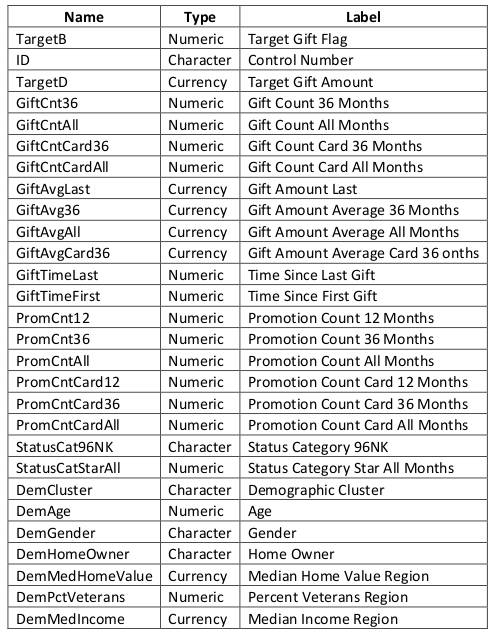

<u>Что нужно сделать?</u>

В рамках первой части задания нужно построить регрессионные модели (только по людям, кто пожертвовал деньги),
объясняющие и прогнозирующие сумму пожертвования TargetD.


In [2]:
import pandas as pd
data = pd.read_csv("donations.csv", index_col= 1)
X= data.drop(columns= ['TargetB', 'TargetD'])
y= data[['TargetB', 'TargetD']]
data

,TargetB,TargetD,GiftCnt36,GiftCntAll,GiftCntCard36,GiftCntCardAll,GiftAvgLast,GiftAvg36,GiftAvgAll,GiftAvgCard36,...,PromCntCardAll,StatusCat96NK,StatusCatStarAll,DemCluster,DemAge,DemGender,DemHomeOwner,DemMedHomeValue,DemPctVeterans,DemMedIncome
ID,,,,,,,,,,,,,,,,,,,,,
14974,0,NaN,2,4,1,3,17.0,13.50,9.25,17.00,...,13,A,0,0,NaN,F,U,0,0,NaN
6294,0,NaN,1,8,0,3,20.0,20.00,15.88,NaN,...,24,A,0,23,67.0,F,U,186800,85,NaN
46110,1,4.0,6,41,3,20,6.0,5.17,3.73,5.00,...,22,S,1,0,NaN,M,U,87600,36,38750.0
185937,1,10.0,3,12,3,8,10.0,8.67,8.50,8.67,...,16,E,1,0,NaN,M,U,139200,27,38942.0
29637,0,NaN,1,1,1,1,20.0,20.00,20.00,20.00,...,6,F,0,35,53.0,M,U,168100,37,71509.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2796,1,25.0,2,2,2,2,10.0,15.00,15.00,15.00,...,11,N,0,44,NaN,M,H,68200,38,45909.0
184939,0,NaN,3,4,1,1,10.0,13.33,11.50,10.00,...,13,A,0,44,NaN,U,H,71900,35,50530.0
184974,1,10.0,9,14,5,7,10.0,8.78,7.71,8.80,...,18,S,1,40,71.0,F,H,115700,32,NaN


In [3]:
# это все понадобиться в дальнейшем, т.к. наш TargetD имеет пик в 0 и длинный правый хвост
import numpy as np
from sklearn.impute import SimpleImputer
y['TargetD'] = SimpleImputer(fill_value= 0, strategy= 'constant').fit_transform(y[['TargetD']])
y['TargetD'] = np.log1p(y['TargetD'])

/tmp/ipykernel_6641/3647011823.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['TargetD'] = SimpleImputer(fill_value= 0, strategy= 'constant').fit_transform(y[['TargetD']])
/tmp/ipykernel_6641/3647011823.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['TargetD'] = np.log1p(y['TargetD'])


## Условие 2

1) Выберите и сохраните в качестве проверочной выборки (holdout) 30% исходной выборки со
стратификацией по отклику. 
2) Обратите внимание, что отклик непрерывный и его нужно
дискретизировать. Число интервалов и метод дискретизации выберите самостоятельно.
3) Постройте и визуализируйте гистограмму (или kde апроксимацию) для распределения отклика
во всем исходном наборе, в проверочной и в тренировочной выборках.

Источник для стратификации: https://inria.github.io/scikit-learn-mooc/python_scripts/cross_validation_stratification.html

### Методы дискретизации непрерывного отклика и краткое описание, как они работают:



1) Uniform (equal-width)

Делит диапазон значений на равные по ширине интервалы. Простая и понятная схема, но в случае «скошенного» распределения одни бины могут оказаться слишком пустыми, а другие — перегруженными.

2) Quantile (equal-frequency)

Делит данные на интервалы так, чтобы в каждом бине было примерно одинаковое число наблюдений (квантильная разбивка). Хорошо подходит для сохранения баланса, но интервалы могут получаться очень узкими там, где данные сконцентрированы.

3) KMeans

Использует алгоритм K-means: центры кластеров определяют «средние» значения бинов. Позволяет более гибко следовать за формой распределения, особенно при наличии нескольких «горбов».

4) Custom bins

Вы сами задаёте границы бинов, исходя из предметной области или бизнес-требований (например, тарифные зоны, возрастные категории и т.д.).

![Снимок экрана от 2025-04-29 11-48-07.png](<attachment:Снимок экрана от 2025-04-29 11-48-07.png>)
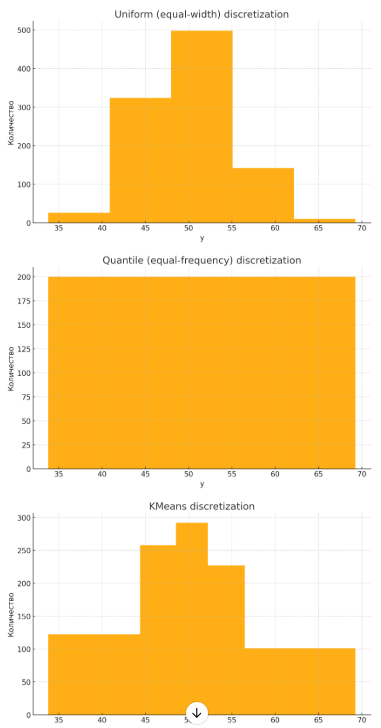

<Axes: >

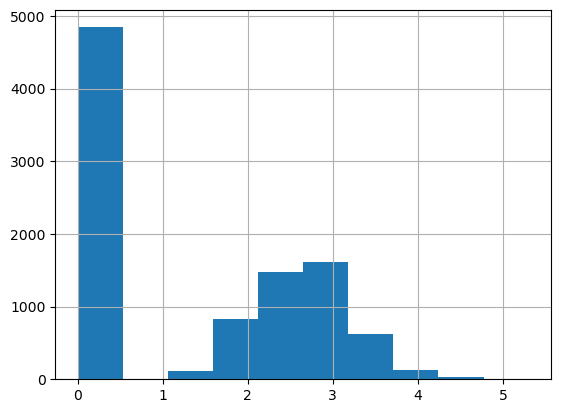

In [4]:
# Перед определением кол-ва бинов посмотрим на данные
y['TargetD'].hist()

In [5]:
condition = (y['TargetB'] == 0) & (y['TargetD'].isna())
print(condition.sum())
print((y['TargetB'] == 0).sum())
# числа совпали следовательно если в TargetB стоит 0, то в TargetD NaN значение

0
4843


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer

# дискратизация с помощью Kmeans
discretizer = KBinsDiscretizer(n_bins= 5,
                               strategy= 'quantile',
                               encode= 'ordinal')
y_binned = discretizer.fit_transform(y[['TargetD']].fillna(value= 0))

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size= 0.3,
                                                    stratify= y_binned)

/home/ranil/anaconda3/envs/math/lib/python3.13/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


### Визуализация данных после стратификации

array([[<Axes: title={'center': 'TargetB'}>,
        <Axes: title={'center': 'TargetD'}>]], dtype=object)

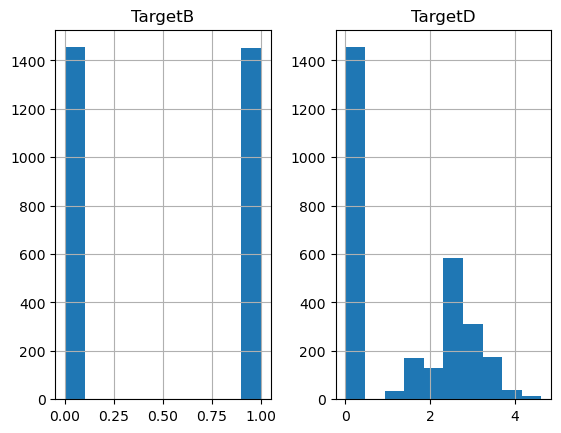

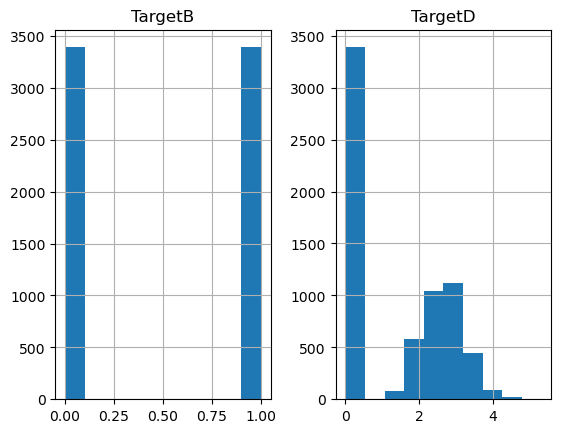

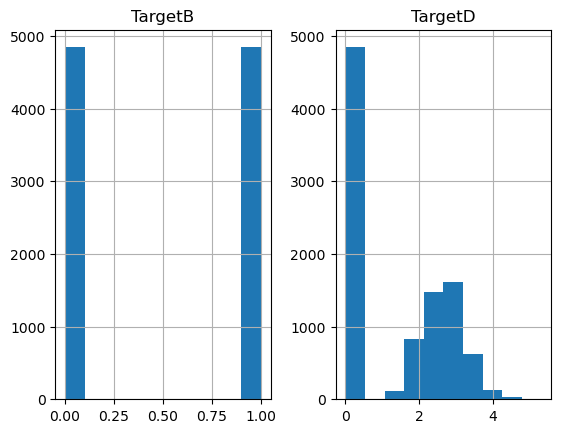

In [7]:
y_test.hist()
y_train.hist()
y.hist()

Вывод:

Стратификация прошла успешно

### Создадим небольшую функцию

In [8]:
def Stratification_data(X, y):
    discretizer = KBinsDiscretizer(n_bins= 5,
                                   strategy= 'quantile',
                                   encode= 'ordinal')
    y_binned = discretizer.fit_transform(y[['TargetD']].fillna(value= 0))
    
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y,
                                                        test_size= 0.3,
                                                        stratify= y_binned)
    return X_train, X_test, y_train, y_test

## Условие 3

- На этапе предобработки данных сделайте подстановку пропусков методом KnnImputer (neighbors=5)
с сохранением бинарных признаков о том, какие переменные были проимпутированы.

- Преобразования категориальных переменных с помощью WOE, Target encoding, Threshold
encoding и других методов 

- А также преобразование числовых переменных (для получения
более симметричных распределений с помощью log или Box-Cox) приветствуется, но не
обязательно.

<u>KNNImputer</u> — это способ заполнения пропусков (NaN) на основе похожих объектов. Он работает по принципу ближайших соседей (k-nearest neighbors, KNN) и заменяет пропущенные значения на среднее значение признака у ближайших "соседей".

In [9]:
from sklearn.impute import KNNImputer 

def KNN_Imputer(X: pd.DataFrame, with_return_col_category= False):
    print("Всего пропусков было:")
    temp_columns_where_nan_value = X.isna().sum()
    print(temp_columns_where_nan_value[temp_columns_where_nan_value > 0])
    
    mask = ~(X.dtypes == np.object_)
    imputer = KNNImputer(n_neighbors= 5,
                         weights= 'distance',
                         add_indicator= True) # Показывает, где раньше были пропуски
    
    col_name = ['is_changed' + el for el in mask.index[temp_columns_where_nan_value > 0].to_list()]# столбцы по которым были совершены изменения / вставки значений

    temp_df = pd.DataFrame(data= imputer.fit_transform(X.T[mask].T),
                           columns= mask[mask == True].index.to_list() + col_name,
                           index= X.index)

    if with_return_col_category:
        return pd.concat([temp_df, X.T[~mask].T], axis= 1, join= 'inner'), mask[~(mask == True)].index

    
    return pd.concat([temp_df, X.T[~mask].T], axis= 1, join= 'inner')

In [10]:
X_train = KNN_Imputer(X_train)
X_train

Всего пропусков было:
GiftAvgCard36    1217
DemAge           1666
DemMedIncome     1648
dtype: int64


,GiftCnt36,GiftCntAll,GiftCntCard36,GiftCntCardAll,GiftAvgLast,GiftAvg36,GiftAvgAll,GiftAvgCard36,GiftTimeLast,GiftTimeFirst,...,DemAge,DemMedHomeValue,DemPctVeterans,DemMedIncome,is_changedGiftAvgCard36,is_changedDemAge,is_changedDemMedIncome,StatusCat96NK,DemGender,DemHomeOwner
ID,,,,,,,,,,,,,,,,,,,,,
184549,4.0,6.0,2.0,3.0,25.0,23.75,20.83,22.500000,20.0,39.0,...,54.000000,104000.0,34.0,66092.000000,0.0,0.0,0.0,A,M,H
60090,5.0,8.0,5.0,6.0,15.0,11.00,10.63,11.000000,20.0,41.0,...,61.273844,69900.0,37.0,58914.413596,0.0,1.0,1.0,A,M,U
99878,4.0,6.0,3.0,4.0,17.0,11.50,10.00,9.670000,18.0,41.0,...,65.000000,59600.0,30.0,47489.000000,0.0,0.0,0.0,S,F,H
138905,4.0,12.0,3.0,7.0,10.0,9.25,6.92,9.000000,20.0,113.0,...,73.000000,83500.0,48.0,38307.000000,0.0,0.0,0.0,A,F,H
72452,7.0,18.0,1.0,6.0,5.0,4.57,3.33,5.000000,15.0,102.0,...,36.000000,95100.0,40.0,64385.000000,0.0,0.0,0.0,S,F,H
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118905,8.0,16.0,6.0,12.0,5.0,7.50,6.56,7.500000,17.0,105.0,...,54.000000,136200.0,9.0,78765.000000,0.0,0.0,0.0,S,M,H
185803,3.0,14.0,2.0,6.0,20.0,20.00,15.00,20.000000,9.0,125.0,...,59.000000,88700.0,0.0,70928.000000,0.0,0.0,0.0,A,M,H
190891,3.0,15.0,2.0,7.0,15.0,11.67,9.27,12.500000,16.0,91.0,...,66.000000,46200.0,38.0,41669.233709,0.0,0.0,1.0,S,M,U


### Поймем какие уникальные значения в категориальных столбцах

In [11]:
_, category_col = KNN_Imputer(X_train, with_return_col_category= True)
for col in category_col:
    print(X_train[col].value_counts())

Всего пропусков было:
Series([], dtype: int64)
StatusCat96NK
A    4083
S    1683
F     453
N     388
E     154
L      19
Name: count, dtype: int64
DemGender
F    3661
M    2745
U     374
Name: count, dtype: int64
DemHomeOwner
H    3776
U    3004
Name: count, dtype: int64


### Основные Методы преобразования категориальных переменных


### Target Encoding (Целевое кодирование)
- category_encoders.TargetEncoder (библиотека category_encoders)

Категории заменяются на среднее значение целевой переменной для каждой категории.

До преобразования

| Index |  City   | Price |
|-------|---------|--------|
| 0     | Moscow  | 100    |
| 1     | SPB     | 80     |
| 2     | Kazan   | 60     |
| 3     | Moscow  | 120    |
| 4     | SPB     | 90     |
| 5     | Kazan   | 70     |
| 6     | Moscow  | 110    |

---

Среднее значение Price для каждого города

| City   | Средняя Price |
|--------|----------------|
| Kazan  | 65.0           |
| Moscow | 110.0          |
| SPB    | 85.0           |

---

После Target Encoding

| Index |  City   | Price | City_encoded |
|-------|---------|--------|---------------|
| 0     | Moscow  | 100    | 110.0         |
| 1     | SPB     | 80     | 85.0          |
| 2     | Kazan   | 60     | 65.0          |
| 3     | Moscow  | 120    | 110.0         |
| 4     | SPB     | 90     | 85.0          |
| 5     | Kazan   | 70     | 65.0          |
| 6     | Moscow  | 110    | 110.0         |



### Weight of Evidence (WOE) Encoding (Вес доказательства)

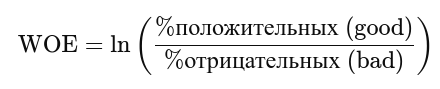

До преобразования

| Index | Job     | Target |
|-------|---------|--------|
| 0     | Admin   | 1      |
| 1     | Worker  | 0      |
| 2     | Manager | 1      |
| 3     | Admin   | 0      |
| 4     | Worker  | 0      |
| 5     | Admin   | 1      |
| 6     | Manager | 0      |

---

Промежуточные расчёты WOE

Считаем долю хороших и плохих:

| Job     | Good (1) | Bad (0) | Total | %Good | %Bad | WOE               |
|---------|----------|---------|--------|--------|------|-------------------|
| Admin   | 2        | 1       | 3      | 2/3   | 1/3  | ln(2/3 ÷ 1/3) = ~0.693 |
| Worker  | 0        | 2       | 2      | 0     | 1    | ln(0 ÷ 1) = -∞*    |
| Manager | 1        | 1       | 2      | 0.5   | 0.5  | ln(0.5 ÷ 0.5) = 0  |

\* В реальности заменяют -∞ на маленькое число (например, -10)

---

После WOE Encoding

| Index | Job     | WOE      |
|-------|---------|----------|
| 0     | Admin   | 0.693    |
| 1     | Worker  | -10      |
| 2     | Manager | 0        |
| 3     | Admin   | 0.693    |
| 4     | Worker  | -10      |
| 5     | Admin   | 0.693    |
| 6     | Manager | 0        |


### Threshold Encoding (часто называют Rare Label Encoding)

До преобразования

| Index | Country     |
|-------|-------------|
| 0     | USA         |
| 1     | Canada      |
| 2     | France      |
| 3     | USA         |
| 4     | USA         |
| 5     | Canada      |
| 6     | Brazil      |
| 7     | Norway      |

---

Порог = 2 вхождения  
Заменим редкие категории на `'Other'`:

| Country     | Count |
|-------------|--------|
| USA         | 3      |
| Canada      | 2      |
| France      | 1      |
| Brazil      | 1      |
| Norway      | 1      |

---

После Threshold Encoding

| Index | Country     | Encoded     |
|-------|-------------|-------------|
| 0     | USA         | USA         |
| 1     | Canada      | Canada      |
| 2     | France      | Other       |
| 3     | USA         | USA         |
| 4     | USA         | USA         |
| 5     | Canada      | Canada      |
| 6     | Brazil      | Other       |
| 7     | Norway      | Other       |

Если больше, чем 2 категории:

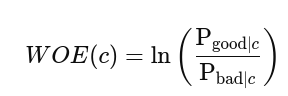

P(good∣c) : доля наблюдений с положительным target в категории 

P(bad∣c) : доля наблюдений с отрицательным target в категории 

### И другие методы

### Ordinal Encoding (Порядковое кодирование)
- sklearn.preprocessing.OrdinalEncoder

Каждая категория заменяется на целое число: 

['low', 'medium', 'high'] → [0, 1, 2].

Используется, если категории имеют естественный порядок.

### One-Hot Encoding (Одноразрядное кодирование)
- pandas.get_dummies() или sklearn.preprocessing.OneHotEncoder

Создаётся отдельный столбец для каждой категории:
['red', 'green', 'blue'] → [[1, 0, 0], [0, 1, 0], [0, 0, 1]]

Используется, когда нет порядка между категориями.



### Frequency / Count Encoding (Частотное или счётное)

Категория заменяется на частоту или количество её вхождений в колонке.


### Hashing Encoding (Хеширование)

- sklearn.feature_extraction.FeatureHasher

Категории преобразуются в фиксированное количество хешированных признаков.
Полезно при очень большом количестве уникальных категорий.



### Binary Encoding

- category_encoders.BinaryEncoder

 Комбинация порядкового и побитового кодирования.

Эффективен при много категорий, но меньше дублирует информацию, чем One-Hot.

До преобразования

| Index |  City   |
|-------|---------|
| 0     | Moscow  |
| 1     | SPB     |
| 2     | Kazan   |
| 3     | Moscow  |
| 4     | SPB     |
| 5     | Kazan   |
| 6     | Moscow  |

---
Binary Encoding

Сначала каждой категории присваивается уникальный **целочисленный код** (Ordinal Encoding):

| City   | Ordinal |
|--------|---------|
| Kazan  | 0       |
| Moscow | 1       |
| SPB    | 2       |

Затем число преобразуется в **двоичную систему** (Binary):

| Ordinal | Binary |
|---------|--------|
| 0       | 0      |
| 1       | 1      |
| 2       | 10     |

Мы обычно добавляем нули слева для выравнивания по длине (до 2 бит):

| Ordinal | Binary | Bin_0 | Bin_1 |
|---------|--------|-------|-------|
| 0       | 00     | 0     | 0     |
| 1       | 01     | 1     | 0     |
| 2       | 10     | 0     | 1     |

---

После Binary Encoding

| Index |  City   | Bin_0 | Bin_1 |
|-------|---------|--------|--------|
| 0     | Moscow  | 1      | 0      |
| 1     | SPB     | 0      | 1      |
| 2     | Kazan   | 0      | 0      |
| 3     | Moscow  | 1      | 0      |
| 4     | SPB     | 0      | 1      |
| 5     | Kazan   | 0      | 0      |
| 6     | Moscow  | 1      | 0      |


### Преобразуем категориальные переменные с помощью WOE
т.к. он лучше всего учитывает связь с target-м и это будет давать преисущество в обучении линейной модели в дальнейшем

In [12]:
import category_encoders as ce
def category_encoding(X, y, cols, encoder = 'one_hot'):
    match encoder:

        case 'WOE':
            incoder = ce.WOEEncoder(cols= cols)
            return incoder.fit_transform(X, y)
        
        case 'one_hot':
            return pd.concat([X.drop(cols, axis=1), pd.get_dummies(X[cols])], axis=1)

In [13]:
X_train = category_encoding(X_train, y_train['TargetB'], category_col)
X_train

,GiftCnt36,GiftCntAll,GiftCntCard36,GiftCntCardAll,GiftAvgLast,GiftAvg36,GiftAvgAll,GiftAvgCard36,GiftTimeLast,GiftTimeFirst,...,StatusCat96NK_E,StatusCat96NK_F,StatusCat96NK_L,StatusCat96NK_N,StatusCat96NK_S,DemGender_F,DemGender_M,DemGender_U,DemHomeOwner_H,DemHomeOwner_U
ID,,,,,,,,,,,,,,,,,,,,,
184549,4.0,6.0,2.0,3.0,25.0,23.75,20.83,22.500000,20.0,39.0,...,False,False,False,False,False,False,True,False,True,False
60090,5.0,8.0,5.0,6.0,15.0,11.00,10.63,11.000000,20.0,41.0,...,False,False,False,False,False,False,True,False,False,True
99878,4.0,6.0,3.0,4.0,17.0,11.50,10.00,9.670000,18.0,41.0,...,False,False,False,False,True,True,False,False,True,False
138905,4.0,12.0,3.0,7.0,10.0,9.25,6.92,9.000000,20.0,113.0,...,False,False,False,False,False,True,False,False,True,False
72452,7.0,18.0,1.0,6.0,5.0,4.57,3.33,5.000000,15.0,102.0,...,False,False,False,False,True,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118905,8.0,16.0,6.0,12.0,5.0,7.50,6.56,7.500000,17.0,105.0,...,False,False,False,False,True,False,True,False,True,False
185803,3.0,14.0,2.0,6.0,20.0,20.00,15.00,20.000000,9.0,125.0,...,False,False,False,False,False,False,True,False,True,False
190891,3.0,15.0,2.0,7.0,15.0,11.67,9.27,12.500000,16.0,91.0,...,False,False,False,False,True,False,True,False,False,True


1

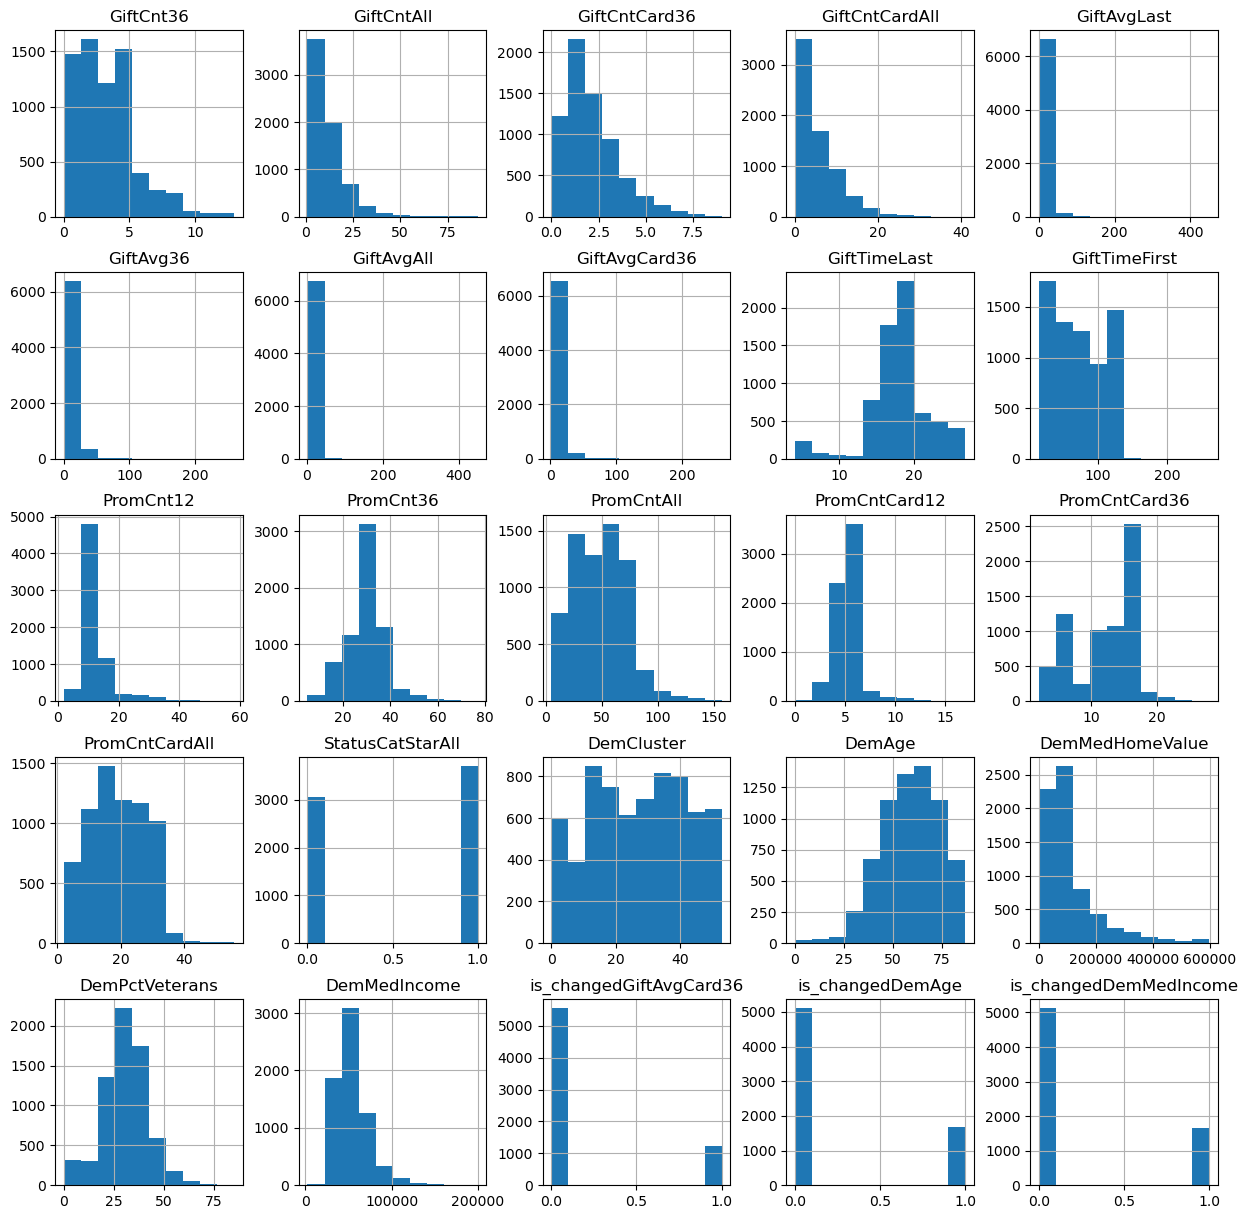

In [14]:
X_train.hist(figsize= (15, 15))
1

### Вывод

Вот признаки, для которых логарифмическое преобразование будет наиболее полезно:

log_columns = [
    "GiftCnt36",
    "GiftCntAll",
    "GiftCntCard36",
    "GiftCntCardAll",
    "GiftAvgLast",
    "GiftAvg36",
    "GiftAvgAll",
    "GiftAvgCard36",
    "DemMedHomeValue",
    "DemPctVeterans",
    "DemMedIncome"
]



У этих признаков распределение выражено скошено вправо, и логарифмическое преобразование может помочь сделать распределение ближе к нормальному, уменьшить влияние выбросов и улучшить работу моделей машинного обучения.

/tmp/ipykernel_6641/1927274061.py:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return X[log_columns].applymap(np.log1p)


1

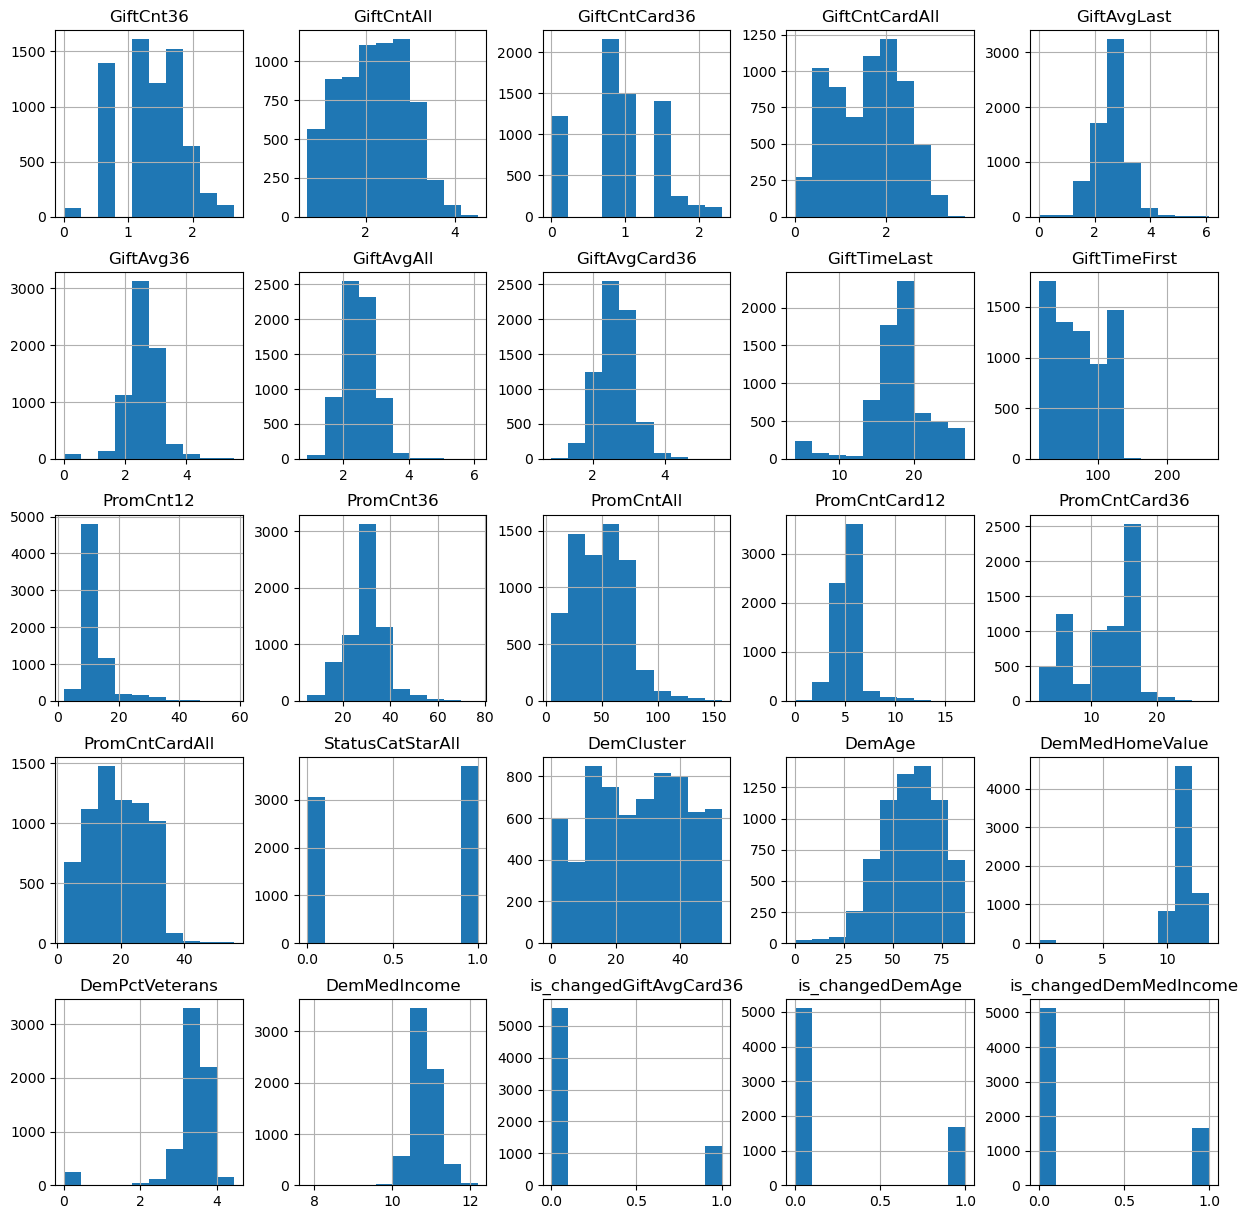

In [15]:
LOG_COLUMNS = [
    "GiftCnt36",
    "GiftCntAll",
    "GiftCntCard36",
    "GiftCntCardAll",
    "GiftAvgLast",
    "GiftAvg36",
    "GiftAvgAll",
    "GiftAvgCard36",
    "DemMedHomeValue",
    "DemPctVeterans",
    "DemMedIncome"
]

def log_encoding(X:pd.DataFrame, log_columns):
    return X[log_columns].applymap(np.log1p)

X_train[LOG_COLUMNS] = log_encoding(X_train, LOG_COLUMNS)
X_train.hist(figsize= (15, 15))
1

## Условие 4

- Произведите отбор важных переменных с помощью линейного регрессионного метода `LARS`, перебрав все возможные сложности моделей в рамках вашего метода и
выбрав лучшую по кросс-валидации c 5 блоками и MSE в качестве критерия. 

- В пошаговых
регрессионных методах для остановки и выбора следующего шага используйте R-квадрат, p-
value или AIC на ваше усмотрение. 

- Постройте график зависимости CV-MSE от сложности (число
переменных или число компонент в модели), 

- График трассы стандартизованных
коэффициентов от сложности. Вертикальной линией на этих графиках обозначьте лучшую по CV
сложность модели.

Источники пол LARS: 

Про сам метод: https://www.geeksforgeeks.org/least-angle-regression-lars/

Реализация в sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lars

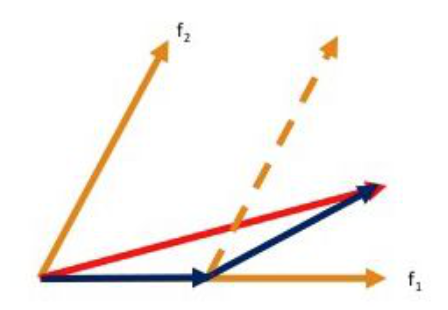


In [16]:
from sklearn.linear_model import LarsCV
# from sklearn.impute import SimpleImputer
# y_train['TargetD'] = SimpleImputer(fill_value= 0, strategy= 'constant').fit_transform(y_train[['TargetD']])

def choose_important_col(X, y):
    lars_cv = LarsCV(cv= 5)
    lars_cv.fit(X, y)
    
    return lars_cv, X.columns[np.where(lars_cv.coef_ != 0)] # отбор важных переменных 

    # атрибут coef_ содержит коэффициенты перед параметрами в линейной регрессии
    # т.е. то как влияет этот признак на Целевую переменную

lars, IMPORTANT_COL = choose_important_col(X_train, y_train['TargetD'])
X_after_use_lars = X_train[IMPORTANT_COL]
X_after_use_lars

,GiftCnt36,GiftCntCard36,GiftAvgLast,GiftAvg36,GiftAvgCard36,GiftTimeLast,GiftTimeFirst,PromCnt12,PromCnt36,PromCntAll,...,StatusCatStarAll,DemCluster,DemAge,DemMedHomeValue,DemMedIncome,is_changedDemAge,is_changedDemMedIncome,StatusCat96NK_F,DemGender_F,DemGender_M
ID,,,,,,,,,,,,,,,,,,,,,
184549,1.609438,1.098612,3.258097,3.208825,3.157000,20.0,39.0,13.0,35.0,37.0,...,0.0,27.0,54.000000,11.552156,11.098818,0.0,0.0,False,False,True
60090,1.791759,1.791759,2.772589,2.484907,2.484907,20.0,41.0,13.0,33.0,37.0,...,1.0,26.0,61.273844,11.154835,10.983858,1.0,1.0,False,False,True
99878,1.609438,1.386294,2.890372,2.525729,2.367436,18.0,41.0,13.0,31.0,33.0,...,1.0,39.0,65.000000,10.995428,10.768274,0.0,0.0,False,True,False
138905,1.609438,1.386294,2.397895,2.327278,2.302585,20.0,113.0,12.0,30.0,66.0,...,1.0,37.0,73.000000,11.332614,10.553414,0.0,0.0,False,True,False
72452,2.079442,0.693147,1.791759,1.717395,1.791759,15.0,102.0,13.0,31.0,55.0,...,1.0,39.0,36.000000,11.462695,11.072651,0.0,0.0,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118905,2.197225,1.945910,1.791759,2.140066,2.140066,17.0,105.0,14.0,35.0,69.0,...,1.0,24.0,54.000000,11.821887,11.274237,0.0,0.0,False,False,True
185803,1.386294,1.098612,3.044522,3.044522,3.044522,9.0,125.0,20.0,42.0,80.0,...,0.0,0.0,59.000000,11.393026,11.169435,0.0,0.0,False,False,True
190891,1.386294,1.098612,2.772589,2.539237,2.602690,16.0,91.0,14.0,34.0,59.0,...,1.0,16.0,66.000000,10.740757,10.637542,0.0,1.0,False,False,True


In [17]:
"""
В mse_path находится  mse после каждого шага для каждого FOLD-а

[[15.2, 14.8, 16.1, 15.5, 14.9],  # MSE на шаге 1 для 5 фолдов
 [12.3, 11.9, 13.0, 12.6, 12.1],   # Шаг 2
 ...
 [10.1, 10.0, 10.3,  9.8, 10.2]]    # Шаг 10
"""
lars.mse_path_.shape

(200, 5)

158 шагов сделано в каждом FOLD, т.к. помимо отбора переменных LARS делает микрокорректировки 

### Построем график зависимости CV-MSE от сложности (число шагов)

Best MSE= 1.88


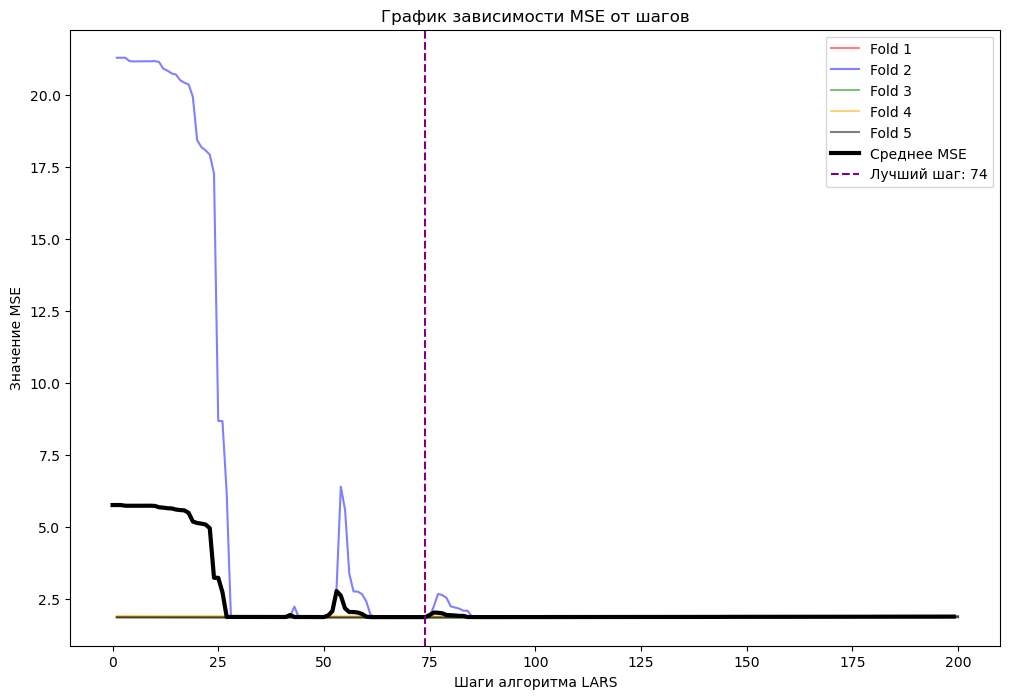

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
colors = ['red', 'blue', 'green', 'orange', 'black']

for i, one_fold in enumerate(lars.mse_path_.T):
    plt.plot(range(1, len(one_fold) + 1), one_fold, 
             label= f'Fold {i + 1}',
             color= colors[i],
             alpha= 0.5)

mean_mse = np.mean(lars.mse_path_, axis=1)
plt.plot(mean_mse, 
         color='black', 
         linewidth=3, 
         label='Среднее MSE')

best_step = np.argmin(mean_mse)
plt.axvline(best_step, 
            color='purple', 
            linestyle='--',
            label=f'Лучший шаг: {best_step}')
print(f"Best MSE= {mean_mse[best_step]:.2f}")
plt.xlabel('Шаги алгоритма LARS')
plt.ylabel('Значение MSE')
plt.title('График зависимости MSE от шагов')
plt.legend()
plt.show()

### Построем график трассы стандартизованных коэффициентов от сложности.

In [19]:
lars.coef_path_.shape

(36, 25)

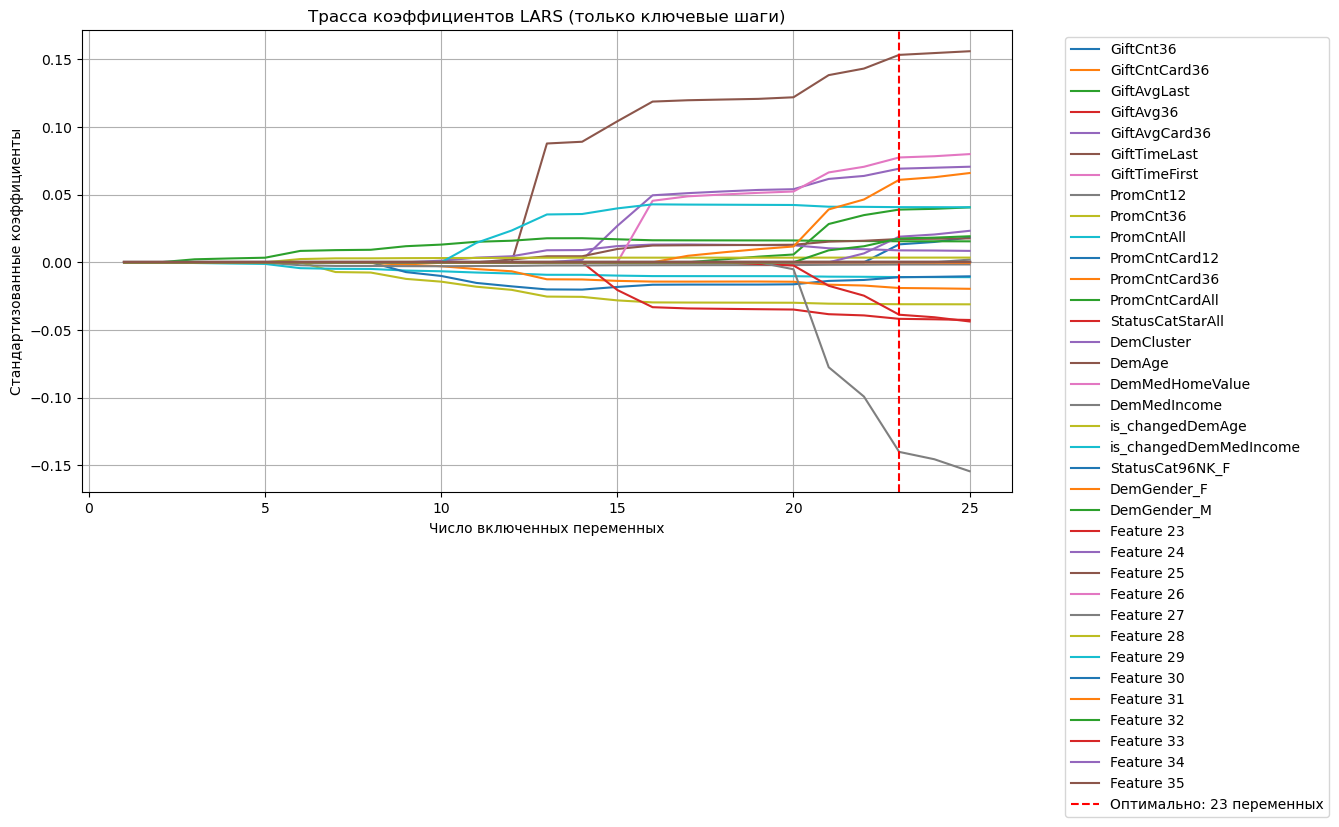

In [20]:
# Рассчитываем число активных признаков на каждом из 16 шагов

plt.figure(figsize=(12, 6))

# Рисуем траекторию каждого коэффициента
for i in range(lars.coef_path_.shape[0]):
    plt.plot(range(1, len(lars.coef_path_[i, :]) + 1), lars.coef_path_[i, :], 
             label=f'{IMPORTANT_COL[i]}' if i < len(IMPORTANT_COL) else f'Feature {i}')

# Отмечаем оптимальную модель
optimal_vars = len(IMPORTANT_COL)
plt.axvline(optimal_vars, color='red', linestyle='--',
           label=f'Оптимально: {optimal_vars} переменных')

plt.xlabel('Число включенных переменных')
plt.ylabel('Стандартизованные коэффициенты')
plt.title('Трасса коэффициентов LARS (только ключевые шаги)')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.grid(True)
plt.show()

## Условие 5

1) Для лучшей выбранной сложности линейной модели с помощью бутстреппинга (100 бутстреп
выборок размера 25% от исходной)  постройте гистограммы (или kde аппроксимацию) распределения константы смещения в полученном регрессионном уравнении (константы b
если регрессии y=ax+b) с указанием на графике среднего значения и 95% интервала.

2) Аналогично оцените OOB ошибку MSE. Как она соотносится с лучшей кросс-валидационной
ошибкой и ошибкой на проверочной части выборки?

Источник к методу sample: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html

`OOB (out of bag) объекты` - это набор данных не вошедший в выборку

Mean_OOB_MSE = 1.89


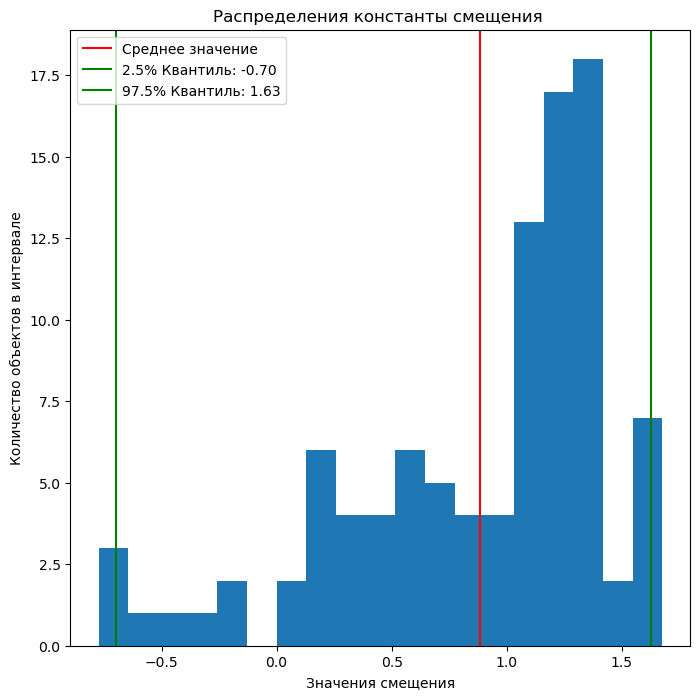

In [21]:
import scipy.stats as ss
from sklearn.metrics import mean_squared_error 
N_BOOTSRAP = 100

intercepts = []
oob_mse = []
plt.figure(figsize=(8, 8))

for _ in range(N_BOOTSRAP):
    X_samples = X_after_use_lars.sample(frac= 0.25, # 25% выборки
                                        replace=  False) # Нельзя выбирать одни и теже данные
    y_sample = y_train.loc[X_samples.index]
    
    OOB_sample_mask = ~X_after_use_lars.index.isin(X_samples.index)
    OOB_samples = X_after_use_lars.loc[OOB_sample_mask]

    temp_lars = LarsCV(cv= 5)
    temp_lars.fit(X_samples, y_sample['TargetD'])

    intercepts.append(temp_lars.intercept_)

    oob_mse.append(mean_squared_error(y_true= y_train['TargetD'][OOB_sample_mask], 
                                      y_pred= temp_lars.predict(OOB_samples)))

# Посчитаем среднее значение и 95% интервал
mean = np.mean(intercepts)
interval = (np.quantile(a= intercepts, q= 0.025),
            np.quantile(a= intercepts, q= 0.975))

print(f"Mean_OOB_MSE = {np.mean(oob_mse):.2f}")

# Визуализация
plt.hist(x= intercepts, bins= np.linspace(start= min(intercepts), 
                                          stop= max(intercepts),
                                          num= 20))

plt.axvline(x= mean, color= 'red', label= 'Среднее значение')
plt.axvline(x= interval[0], color= 'green', label= f'2.5% Квантиль: {interval[0]:.2f}')
plt.axvline(x= interval[1], color= 'green', label= f'97.5% Квантиль: {interval[1]:.2f}')

plt.legend()
plt.title('Распределения константы смещения ')
plt.xlabel('Значения смещения')
plt.ylabel('Количество объектов в интервале')
plt.show()

### Вывод 

MEAN_OOB_MSE и BEST_MSE почти совпали, это можно увидеть на скриншотах ниже, что означает, что OOB_MSE может отражать реальное MSE, но надо внимательно смотреть на распределение, которое получается на гистограмме


### Протестируем на ТЕСТОВОМ наборе данных

Для этого нужно привести данные в тестовом наборе в похожий вид обучающей выборки.

Воспользуемся функциями приготовленными заранее

In [22]:
X_test = KNN_Imputer(X_test)
X_test = category_encoding(X_test, y_test['TargetB'], category_col)
X_test[LOG_COLUMNS] = log_encoding(X_test, LOG_COLUMNS)

Всего пропусков было:
GiftAvgCard36    563
DemAge           741
DemMedIncome     709
dtype: int64


/tmp/ipykernel_6641/1927274061.py:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return X[log_columns].applymap(np.log1p)


In [23]:
# y_test['TargetD'] = SimpleImputer(fill_value= 0, 
#                                   strategy= 'constant').fit_transform(y_test[['TargetD']])

mse_for_test_data = mean_squared_error(y_true= y_test['TargetD'], 
                                       y_pred= lars.predict(X_test))
print(f'MSE на тестовом наборе данных = {mse_for_test_data:.2f}')

MSE на тестовом наборе данных = 1.89


### Вывод 

Сравнение ошибок:

- Все три ошибки близки по величине (разница < 6%)

- Test MSE даже немного лучше, чем OOB и CV оценки

- Это указывает на устойчивость модели и отсутствие переобучения

In [24]:
np.var(y_train['TargetD'])

1.90030674636516


Если дисперсия TargetD значительно выше 130, модель можно считать адекватной

НО 

R²-скор (коэффициент детерминации) можно оценить как:

R2 ≈ 1 − MSE / Дисперсия

Это означает, что модель объясняет всего R2 дисперсии данных, 
Наше значение близко к 0, что считается слабым результатом.

## Улсовие 6

Используйте отобранные переменные для построения нелинейной модели прогнозирования
числового отклика с помощью метода `Gamma Regression`, 

при этом отбирая метапараметры
с помощью метода `HalvingRandomSearchCV`. 

---
Замечания:
- Обратите внимание, что категориальные переменные можно либо включить в модель
целиком (со всеми уровнями), либо не включать.
- Для Gamma Regression можно варировать константу регуляризации и степень полинома (для Gamma и Poisson воспользуйтесь
PolynomialFeatures)

`Gamma regression` — это разновидность обобщённой линейной модели (GLM), используемая, когда зависимая переменная (таргет) принимает только положительные непрерывные значения и обладает асимметричным распределением, похожим на гамма-распределение.

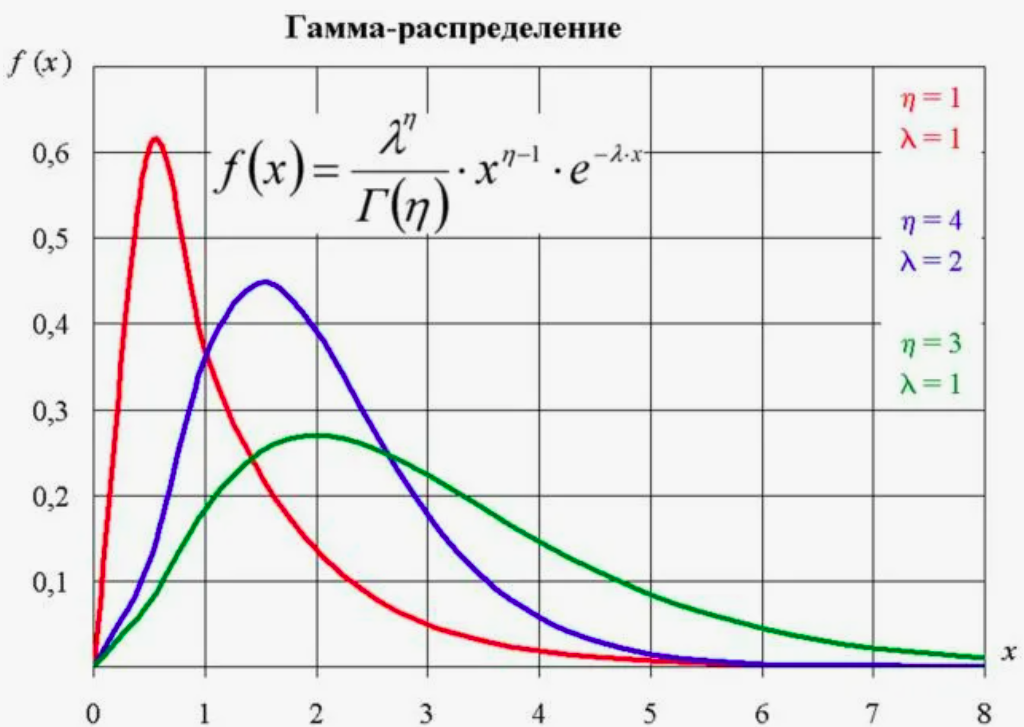

Алгоритм такой же, как у линейной регрессии, но в качестве 

- y_pred = log(~yi) = Xibi --> ~yi = exp(Xibi)

- LOSS = MLE 

Пытаемся максимизировать с помощью ММП, где плотность - это плотность гаммы распределения

1

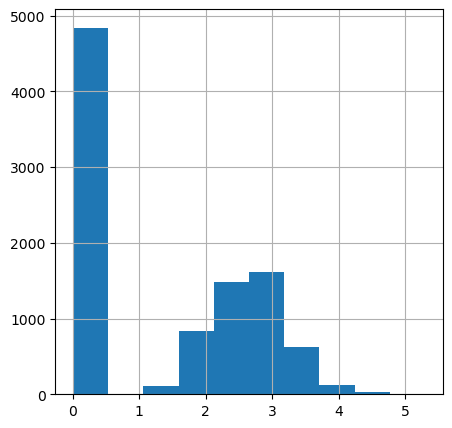

In [25]:
# Посмотрим содержит ли наша целевая переменная отрицательные значения
y['TargetD'].hist(figsize= (5, 5))
1

`HalvingRandomSearchCV`

<u>Идея:</u> 
Вместо того, чтобы обучать все модели на всех данных, мы:

1) Генерируем много случайных комбинаций гиперпараметров.

2) Обучаем их на небольшом количестве данных (ресурсов).

3) Оставляем только лучшие и увеличиваем им ресурс.

4) Повторяем, пока не останется один (или несколько) финалистов.

<u>Как это выглядит?</u>

| Итерация | Кол-во конфигураций | Ресурс (например, кол-во данных или эпох) |
| -------- | ------------------- | ----------------------------------------- |
| 1        | 27                  | 20% данных                                |
| 2        | 9                   | 40% данных                                |
| 3        | 3                   | 80% данных                                |
| 4        | 1                   | 100% данных                               |


`RandomizedSearchCV`

- Проверяется на всех данных и единажды (он медленнее)

### Какие еще модели для поиска есть?

| Метод                     | Описание                                                            | Поддержка в `scikit-learn`                                              |
| ------------------------- | ------------------------------------------------------------------- | ----------------------------------------------------------------------- |
| **Grid Search**           | Полный перебор всех возможных комбинаций. Очень затратный.          | ✅ `GridSearchCV`                                                        |
| **Random Search**         | Случайный перебор (быстрее, охватывает больше пространство).        | ✅ `RandomizedSearchCV`                                                  |
| **Halving Grid Search**   | Итеративный перебор из `GridSearchCV` с постепенным отбором лучших. | ✅ `HalvingGridSearchCV`                                                 |
| **Halving Random Search** | Итеративный перебор из `RandomizedSearchCV`.                        | ✅ `HalvingRandomSearchCV`                                               |
| **Bayesian Optimization** | Строит модель вероятности лучших параметров, выбирает умно.         | ❌ (в `scikit-learn`, но есть в `optuna`, `scikit-optimize`, `hyperopt`) |
| **Evolutionary Search**   | Генетические алгоритмы — комбинируют параметры как "гены".          | ❌ (есть в `deap`, `TPOT`, и др.)                                        |
| **Successive Halving**    | Общая идея, на которой основаны `Halving*SearchCV`.                 | ✅ (через Halving методы)                                                |

In [26]:
from sklearn.linear_model import GammaRegressor
from sklearn.experimental import enable_halving_search_cv # добавляет в model_selection HalvingRansomSearchCV
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

pipeline = Pipeline([('polynom', PolynomialFeatures()),
                     ("gamma", GammaRegressor(max_iter=1000,  # Увеличиваем количество итераций
                                              tol=1e-4,       # Более мягкий критерий сходимости
                    ))])

param_dist = {'polynom__degree' : [2, 3, 4],
              'gamma__alpha':  [0.1, 0.25, 0.5, 1, 2, 5, 10, 20]}

search = HalvingRandomSearchCV(estimator=  pipeline,
                                param_distributions= param_dist,
                                cv= 5)
search.fit(X_train, y_train['TargetD'] + 1e-6)


/home/ranil/anaconda3/envs/math/lib/python3.13/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 24 is smaller than n_iter=678. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/ranil/anaconda3/envs/math/lib/python3.13/site-packages/sklearn/linear_model/_glm/glm.py:441: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - (deviance + constant) / (deviance_null + constant)
/home/ranil/anaconda3/envs/math/lib/python3.13/site-packages/sklearn/linear_model/_glm/glm.py:441: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - (deviance + constant) / (deviance_null + constant)
/home/ranil/anaconda3/envs/math/lib/python3.13/site-packages/sklearn/linear_model/_glm/glm.py:441: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - (deviance + constant) / (deviance_null + constant)
/home/ranil/anaconda3/envs/math/lib/python3.13/site-packages/sklearn/line

HalvingRandomSearchCV(estimator=Pipeline(steps=[('polynom',
                                                 PolynomialFeatures()),
                                                ('gamma',
                                                 GammaRegressor(max_iter=1000))]),
                      param_distributions={'gamma__alpha': [0.1, 0.25, 0.5, 1,
                                                            2, 5, 10, 20],
                                           'polynom__degree': [2, 3, 4]})

## Условие 7
- Постройте график – «решетку» перебора метапараметров, цветом указав качество моделей, а
размером точек – число повторов для halving. 
- Сравните CV, OOB и holdout оценки качества
полученных линейных и нелинейных моделей, какие выводы из этого можно сделать?

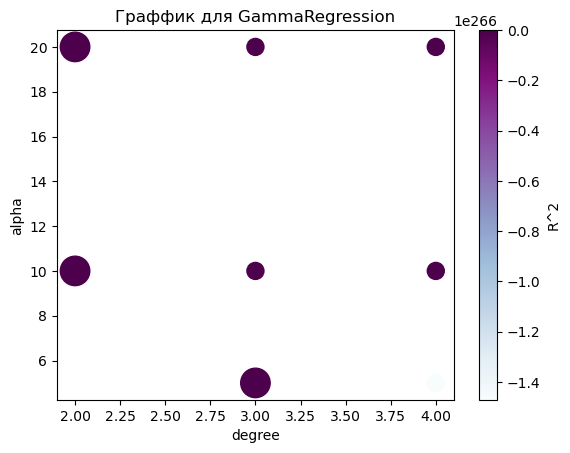

In [68]:
results = search.cv_results_

params = results['params']
scores = results['mean_test_score']
n_iter = results['n_resources']


x_axis = [el['polynom__degree'] for el in params]
y_axis = [el['gamma__alpha'] for el in params]

scatter = plt.scatter(x= x_axis,
            y= y_axis,
            c= scores,
            cmap= 'BuPu',
            s= n_iter * 5)

plt.ylabel("alpha")
plt.xlabel("degree")
plt.title('Граффик для GammaRegression')
plt.colorbar(scatter)
plt.show()

/home/ranil/anaconda3/envs/math/lib/python3.13/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 16 is smaller than n_iter=678. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/tmp/ipykernel_6641/4278935129.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


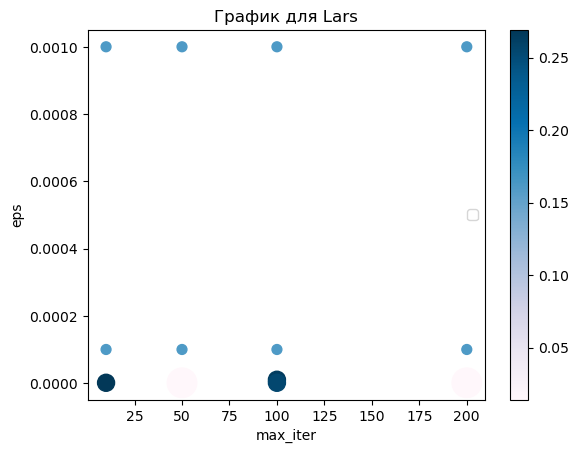

In [70]:
model = LarsCV(cv= 5)

param_grid = {
    'max_iter': [10, 50, 100, 200],
    'eps': [1e-3, 1e-4, 1e-5, 1e-6]
}

search_lars = HalvingRandomSearchCV(estimator= model,
                                    param_distributions= param_grid,
                                    cv= 5)

search_lars.fit(X_train, y_train['TargetD'])

res = search_lars.cv_results_
params = res['params']
scores = res["mean_train_score"]
n_iter_lars = res["n_resources"]

x_axis= [el['max_iter'] for el in params]
y_axis = [el['eps'] for el in params]

scatter = plt.scatter(x= x_axis,
            y= y_axis,
            s= n_iter_lars * 5,
            c= scores,
            cmap= 'PuBu')

plt.colorbar(scatter)

plt.legend()
plt.title("График для Lars")
plt.xlabel("max_iter")
plt.ylabel("eps")
plt.show()

### OOB

/home/ranil/anaconda3/envs/math/lib/python3.13/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/ranil/anaconda3/envs/math/lib/python3.13/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/ranil/anaconda3/envs/math/lib/python3.13/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.



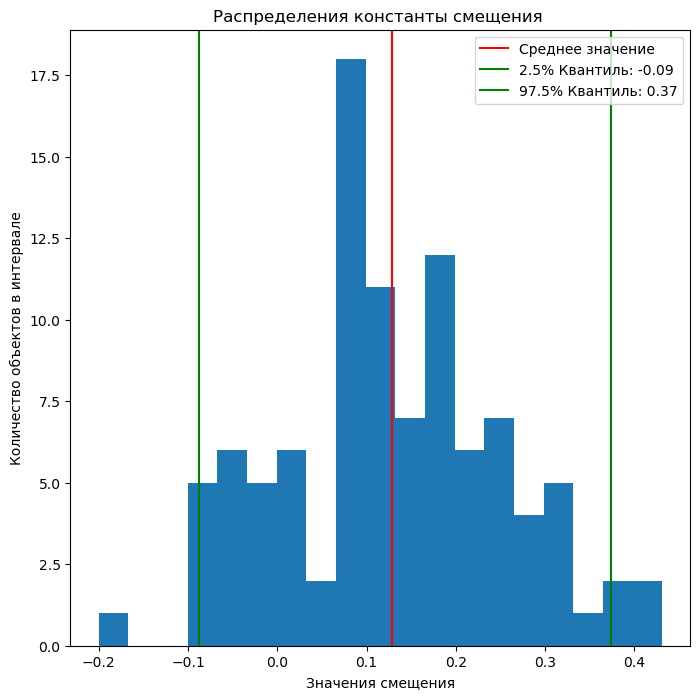

Mean_OOB_MSE = 1.89


In [ ]:
intercepts = []
oob_mse = []
plt.figure(figsize=(8, 8))

for _ in range(N_BOOTSRAP):
    X_samples = X_after_use_lars.sample(frac= 0.25, # 25% выборки
                                        replace=  False) # Нельзя выбирать одни и теже данные
    y_sample = y_train.loc[X_samples.index]
    
    OOB_sample_mask = ~X_after_use_lars.index.isin(X_samples.index)
    OOB_samples = X_after_use_lars.loc[OOB_sample_mask]

    temp_gamma = GammaRegressor(alpha=search.best_params_['gamma__alpha'])
    temp_gamma.fit(X_samples, y_sample['TargetD'] + 1e-6)

    intercepts.append(temp_gamma.intercept_)

    oob_mse.append(mean_squared_error(y_true= y_train['TargetD'][OOB_sample_mask] + 1e-6, 
                                      y_pred= temp_gamma.predict(OOB_samples)))

# Посчитаем среднее значение и 95% интервал
mean = np.mean(intercepts)
interval = (np.quantile(a= intercepts, q= 0.025),
            np.quantile(a= intercepts, q= 0.975))

# Визуализация
plt.hist(x= intercepts, bins= np.linspace(start= min(intercepts), 
                                          stop= max(intercepts),
                                          num= 20))

plt.axvline(x= mean, color= 'red', label= 'Среднее значение')
plt.axvline(x= interval[0], color= 'green', label= f'2.5% Квантиль: {interval[0]:.2f}')
plt.axvline(x= interval[1], color= 'green', label= f'97.5% Квантиль: {interval[1]:.2f}')

plt.legend()
plt.title('Распределения константы смещения ')
plt.xlabel('Значения смещения')
plt.ylabel('Количество объектов в интервале')
plt.show()
print(f"Mean_OOB_MSE = {np.mean(oob_mse):.2f}")

### На тестовом наборе данных

In [76]:
poly = PolynomialFeatures(degree=search.best_params_['polynom__degree'])
temp_df = poly.fit_transform(X_train) 
temp_df_test = poly.transform(X_test) 

gamma_reg = GammaRegressor(alpha=search.best_params_['gamma__alpha'])
gamma_reg.fit(temp_df, y_train['TargetD'] + 1e-6)

y_pred = gamma_reg.predict(temp_df_test)
mse = mean_squared_error(y_true=y_test['TargetD'] + 1e-6, y_pred=y_pred)

print(f"MSE: {mse:.2f}")

MSE: 1.88


/home/ranil/anaconda3/envs/math/lib/python3.13/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


### Вывод
- CV, OOB и holdout оценки качества полученных линейных и нелинейных моделей, очень схожи. 
И модели работают плохо, т.к. R^2 ~ 0